In [58]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import torch
from transformers import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "21st_year"
MODEL = 'bert-base-uncased'

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/21st_year/tr_tokens.csv
Loaded 2225 TRs.


# Syntactic Complexity

In [ ]:
foo.process_stimulus_attentions()
foo.process_stimulus_activations()

In [ ]:
foo.mask_non_tr_attentions()

In [ ]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p=2)
foo.compute_attention_head_magnitudes(p='inf')

In [34]:
# file_name = "{}-{}-full_df.pkl".format(STIMULUS, MODEL)
# foo.stimulus_df.to_pickle(file_name)

In [ ]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[10][0][11])

In [ ]:
foo.compute_attention_head_distances()

In [ ]:
sns.heatmap(foo.stimulus_df.attention_distances.iloc[15])

In [37]:
# foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)
# file_name = "{}-{}-full_df.pkl".format(STIMULUS, MODEL)

# try:
#     df = pd.read_pickle(file_name)
#     foo.stimulus_df = df
       
# except:
    
#     foo.process_stimulus_attentions()
#     foo.process_stimulus_activations()
#     foo.mask_non_tr_attentions()
    
#     foo.compute_attention_head_magnitudes(p=1)
#     foo.compute_attention_head_magnitudes(p=2)
#     foo.compute_attention_head_magnitudes(p='inf')
    
#     foo.stimulus_df.to_pickle(file_name)


# Outputs for Sreejan

### Syntactic Complexity

In [ ]:
import itertools

p='inf'

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))
foo.stimulus_df["attention_heads_L{}_vector".format(p)] = attention_vectors

for_output = foo.stimulus_df[["attention_heads_L{}_vector".format(p)]]
for_output.to_pickle("{}_{}_syntactic_complexity_L-{}.pkl".format(STIMULUS, MODEL, p), protocol=4)

In [ ]:
baz = pd.read_pickle("{}_{}_syntactic_complexity_L-{}.pkl".format(STIMULUS, MODEL, p))
baz.head(10)

### Syntactic Distance

In [ ]:
attention_vectors = foo.stimulus_df["attention_distances".format(p)].apply(lambda x: flatten(x))
foo.stimulus_df["attention_distances_vector"] = attention_vectors

for_output = foo.stimulus_df[["attention_distances_vector"]]
for_output.to_pickle("{}_{}_syntactic_distance.pkl".format(STIMULUS, MODEL), protocol=4)

In [ ]:
pd.read_pickle("{}_{}_syntactic_distance.pkl".format(STIMULUS, MODEL)).head(10)

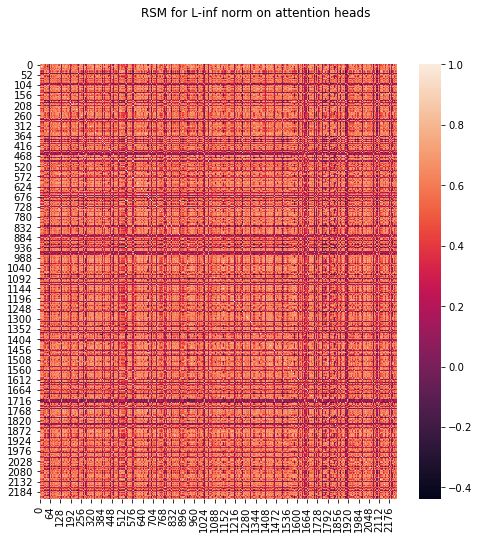

In [9]:
non_null = for_output[~pd.isnull(for_output["attention_heads_L{}_vector".format(p)])]

non_null_df = pd.DataFrame.from_records(non_null["attention_heads_L{}_vector".format(p)].values)

rsm_df = pd.DataFrame(np.corrcoef(non_null_df))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df)
plt.suptitle("RSM for L-inf norm on attention heads");

# Semantic Composition

(F.K.A "Attention Effects")

### End-to-end
How far do tokens "move in space" from the initial embeddings to final outputs?

`activation_end_to_end_l2_distances[n_token]` gives the start-to-finish displacement of the contextualization process. Longer distances indicates the token's meaning was changed more during contextualization.

In [10]:
foo.end_to_end_token_movement()

def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

foo.stimulus_df["activation_end_to_end_mean_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_max_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))

foo.stimulus_df.activation_end_to_end_mean_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_mean_l2)
foo.stimulus_df.activation_end_to_end_max_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_max_l2)

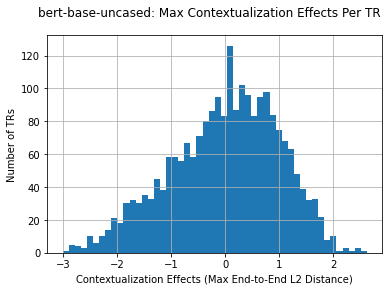

In [11]:
foo.stimulus_df.activation_end_to_end_max_l2.hist(bins=50)
plt.suptitle("{}: Max Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Max End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

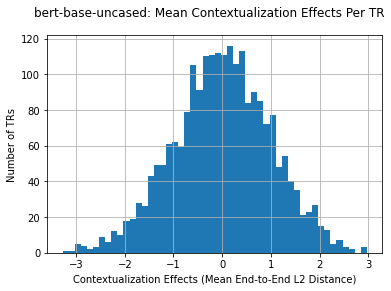

In [12]:
foo.stimulus_df.activation_end_to_end_mean_l2.hist(bins=50)
plt.suptitle("{}: Mean Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Mean End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

### Layerwise
How far do tokens move each layer?

`activation_layerwise_l2_distances[n_layer][n_token]` gives the L2 distance that each token moved, each layer.

We can look at the mean or max distance for each layer + token.

In [13]:
foo.layerwise_token_movement()

len(foo.stimulus_df["activation_layerwise_l2_distances"][0][0])

5

In [14]:
mean_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.mean(layer) for layer in x])
max_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.max(layer) for layer in x])

foo.stimulus_df["activation_layerwise_mean_l2"] = mean_l2_per_layer
foo.stimulus_df["activation_layerwise_max_l2"] = max_l2_per_layer

['what', ',', '25', '?', '26', '?']


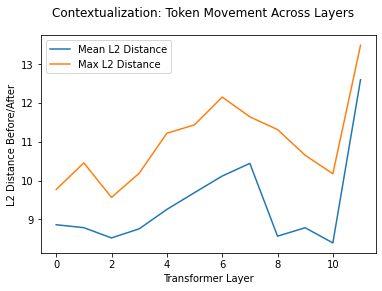

In [15]:
test = foo.stimulus_df.iloc[202]
print(test.transformer_tokens_in_tr)

plt.plot(test["activation_layerwise_mean_l2"], label="Mean L2 Distance")
plt.plot(test["activation_layerwise_max_l2"], label="Max L2 Distance")
plt.xlabel("Transformer Layer")
plt.ylabel("L2 Distance Before/After")
plt.legend(loc='best')
plt.suptitle("Contextualization: Token Movement Across Layers");

In [16]:
metric = "mean" # mean, max

print("Mean / Std of Max L2 Displacement Across Layers: {}, {}".format(STIMULUS, MODEL))
df = pd.DataFrame.from_records(foo.stimulus_df["activation_layerwise_{}_l2".format(metric)])
df.apply([np.mean, np.std])

Mean / Std of Max L2 Displacement Across Layers: 21st_year, bert-base-uncased


,0,1,2,3,4,5,6,7,8,9,10,11
mean,9.165266,8.627666,8.015363,8.133087,8.198541,8.383197,9.765363,9.124418,8.897442,8.859055,7.993110,11.031133
std,0.900571,1.024495,0.938371,0.814093,0.724388,0.757872,0.965824,0.685662,0.738532,0.820616,0.893006,1.022496


In [17]:
normalized = (df-df.mean())/df.std()
normalized.apply([np.mean, np.std])
foo.stimulus_df["activation_layerwise_{}_l2_normed".format(metric)] = [list(r) for r in normalized.to_records(index=False)]

In [18]:
full_lists = []
for i, tr in foo.stimulus_df.iterrows():
    
    all_composition = tr["activation_layerwise_{}_l2_normed".format(metric)] + [tr['activation_end_to_end_{}_l2'.format(metric)]]
    full_lists.append(all_composition)
    
foo.stimulus_df["full_semantic_composition"] = full_lists

In [19]:
foo.stimulus_df.full_semantic_composition

0       [0.4361167724018446, -0.8020786512947615, -0.0...
1       [-0.6888158667895692, -0.5160587813426291, -0....
2       [-0.07135588478784866, -0.6105780373568886, -0...
3       [-0.3622572310492062, -0.3966195963005139, 0.9...
4       [-0.13142538112149002, 0.6245988304055701, -0....
                              ...                        
2220    [-0.611193586365594, -0.29986183552283296, -0....
2221    [-0.5441852363508793, -0.45339516958394827, -0...
2222    [0.549336211058535, 0.40874321498874794, 0.597...
2223    [-0.21063345260747235, -0.6057158555302837, -0...
2224    [0.3276799809395289, 0.19031389117448594, 0.28...
Name: full_semantic_composition, Length: 2225, dtype: object

In [ ]:
foo.stimulus_df.head()

In [64]:
attention_effects_df = foo.stimulus_df[['full_semantic_composition']]
attention_effects_df.to_pickle("{}_{}_semantic_composition_{}_l2.pkl".format(STIMULUS, MODEL, metric), protocol=4)

<AxesSubplot:>

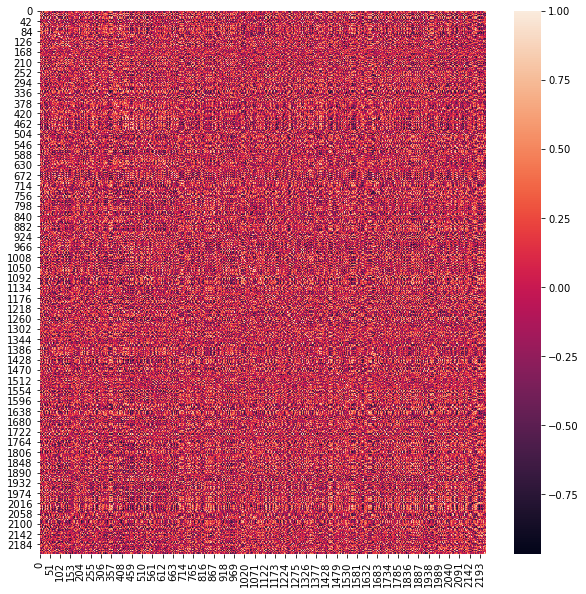

In [65]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(np.corrcoef(normalized)))

In [58]:
baz = pd.read_pickle("{}_{}_semantic_composition_max_l2.pkl".format(STIMULUS, MODEL))
baz.head()

,full_semantic_composition
0,"[0.9101856975233993, -0.22539881902967004, 0.3..."
1,"[0.2519888802353083, 0.8189422287746616, 0.039..."
2,"[0.05071552406909686, -0.26818228838885716, -0..."
3,"[-0.36617933181707424, -0.18907464104196756, 1..."
4,"[-0.4267507863946999, 0.059108150255309466, -0..."


### To upload to PNI

```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/```

```ssh tsumers@apps.pni.princeton.edu```